# Kullback Leibler divergence Estimator by K-Nearest Neighbor 

This notebook is auxiliary to the main notebook, `FinGaN: Generating complex financial data with GANs`, where the `MIXED-WGAN-GP` is applied on the FHL dataset. The main notebook utilizes the Kullback Leibler divergence to evaluate the similarity between the original and synthetic dataset. However, KL divergence only has an analytical formulation for (multivariate) Gaussian distributions. Since financial datasets have their own complex multivariate distribution, we need a way to estimate the KL-divergence numerically. To do so we leverage the below two papers to create an KL-divergence estimator based on a nearest-neighbor approach. 

----

- Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions
- Qing Wang, Sanjeev R. Kulkarni, Sergio Verd´u, 
    A Nearest-Neighbor Approach to Estimating Divergence between Continuous Random Vectors

In [2]:
# Basic libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from scipy.spatial import cKDTree

# ------------------------
# KL ESTIMATOR 
# ------------------------

def KLdivergence(x, y, k=1,  dim= 2):
    """
    Kullback-Leibler estimator in a multivariate non-Gaussian universe.

    x: dataset sampled from distribution P()
    y: dataset sampled from distribution Q() [from the same multivariate universe]
    k: the kth nearest neighbor to compute the distance from in order to estimate the pdf's 
    dim: number of dimensions 
    output: Estimate of D(P||Q) based on KNN density estimates

    see: 
    - Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions
    - Qing Wang, Sanjeev R. Kulkarni, Sergio Verd´u, 
    A Nearest-Neighbor Approach to Estimating Divergence between Continuous Random Vectors
    """
    
    # Parameters 
    
    #add second dimension in case of vectors 
    if dim == 1:
        x= x.reshape(-1,1)
        y= y.reshape(-1,1)
        
    n,d = x.shape
    m,dy = y.shape
    
    # K Nearest Neighbors [KD tree to speed up process, but results in possible mistakes (!)]
    xtree = cKDTree(x)
    ytree = cKDTree(y)

    # Get (euclidian) distance to closest neighbors
    if k == 1:
        r = xtree.query(x, k=2)[0][:,1] #1st "neighbor" is x itself, so we look at 2nd neighbor
        s = ytree.query(x, k=1)[0]
    else:
        r = xtree.query(x, k= k+1)[0][:,-1] #1st "neighbor" is x itself, so we look at 2nd neighbor
        s = ytree.query(x, k= k)[0][:,-1]
    
    # Addendum Paper Pérez-Cruz et al. Eq.14: add negative sign to first right-hand side term (see Qing Wang et al.)
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

## Experimental Results 

In this section we analyse the robustness of our estimator by replicating the work of Wang et al.

### Replicate figure 1 from paper of Wang et al. 

- Exponential Distributions 

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


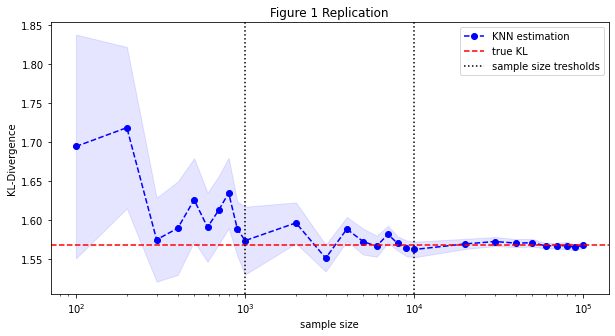

In [ ]:
# Initialize parameters (see pg 246; figure 1)
runs= 25
sampleSizes= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachSize in sampleSizes:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.exponential(1, eachSize)
        s2= np.random.exponential(12, eachSize)
        kl= KLdivergence(s1,s2, k= 10, dim= 1) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)
    
# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(sampleSizes, results, linestyle='--', marker='o', color='b')
plt.fill_between(sampleSizes, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axhline(y= 1.5682, linestyle='--', color='r');
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('sample size')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'true KL', 'sample size tresholds']);
plt.title('Figure 1 Replication'); 

### Replicate figure 2 from paper of Wang et al. 

- 4-dimensional Gaussians with different means and covariance matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


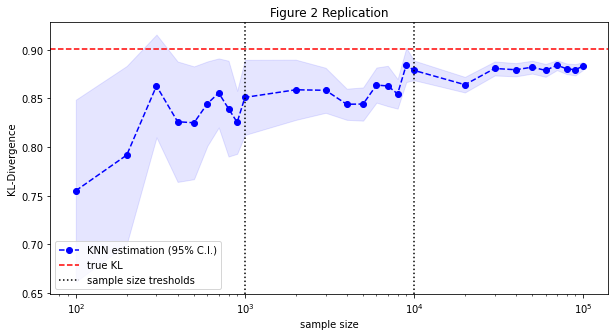

In [ ]:
# Initialize parameters (see pg 246; figure 2)
runs= 25
sampleSizes= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))
mu1= [.1, .3, .6, .9]
mu2= [0, 0, 0, 0]
cov1= [[1, 0.5, 0.5, 0.5], [0.5, 1, 0.5, 0.5], [0.5, 0.5, 1, 0.5], [0.5, 0.5, 0.5, 1] ]
cov2= [[1, 0.1, 0.1, 0.1], [0.1, 1, 0.1, 0.1], [0.1, 0.1, 1, 0.1], [0.1, 0.1, 0.1, 1] ]
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachSize in sampleSizes:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, eachSize)
        s2= np.random.multivariate_normal(mu2, cov2, eachSize)
        kl= KLdivergence(s1,s2) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)
    
# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(sampleSizes, results, linestyle='--', marker='o', color='b')
plt.fill_between(sampleSizes, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axhline(y= 0.9009, linestyle='--', color='r');
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('sample size')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'true KL', 'sample size tresholds']);
plt.title('Figure 2 Replication'); 

### Replicate figure 3 from paper of Wang et al. 

- 10-dimensional Gaussians with same means but different covariance matrix 

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


----------------
sample size finished: 100
----------------
sample size finished: 200
----------------
sample size finished: 300
----------------
sample size finished: 400
----------------
sample size finished: 500
----------------
sample size finished: 600
----------------
sample size finished: 700
----------------
sample size finished: 800
----------------
sample size finished: 900
----------------
sample size finished: 1000
----------------
sample size finished: 2000
----------------
sample size finished: 3000
----------------
sample size finished: 4000
----------------
sample size finished: 5000
----------------
sample size finished: 6000
----------------
sample size finished: 7000
----------------
sample size finished: 8000
----------------
sample size finished: 9000
----------------
sample size finished: 10000


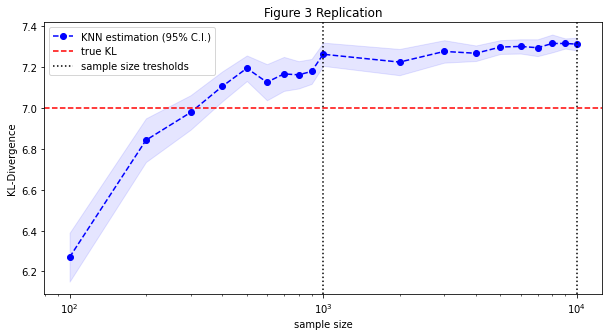

In [ ]:
# Initialize parameters (see pg 246; figure 3)
runs= 25
sampleSizes= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000)))#, np.arange(20000, 110000, 10000)))
mu1= np.zeros(10)
mu2= mu1
cov1= np.ones((10,10))*0.9
np.fill_diagonal(cov1, 1)
cov2= np.ones((10,10))*0.1
np.fill_diagonal(cov2, 1)
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachSize in sampleSizes:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, eachSize)
        s2= np.random.multivariate_normal(mu2, cov2, eachSize)
        kl= KLdivergence(s1,s2, k= 10) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
        #print('run:', eachRun)
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)
    print("----------------")
    print('sample size finished:', eachSize )
    
# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(sampleSizes, results, linestyle='--', marker='o', color='b')
plt.fill_between(sampleSizes, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axhline(y= 6.9990, linestyle='--', color='r');
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('sample size')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'true KL', 'sample size tresholds']);
plt.title('Figure 3 Replication'); 

### Replicate figure 4 from paper of Wang et al. 

- 20-dimensional identical Gaussians

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


----------------
sample size finished: 100
----------------
sample size finished: 200
----------------
sample size finished: 300
----------------
sample size finished: 400
----------------
sample size finished: 500
----------------
sample size finished: 600
----------------
sample size finished: 700
----------------
sample size finished: 800
----------------
sample size finished: 900
----------------
sample size finished: 1000
----------------
sample size finished: 2000
----------------
sample size finished: 3000
----------------
sample size finished: 4000
----------------
sample size finished: 5000
----------------
sample size finished: 6000
----------------
sample size finished: 7000
----------------
sample size finished: 8000
----------------
sample size finished: 9000
----------------
sample size finished: 10000


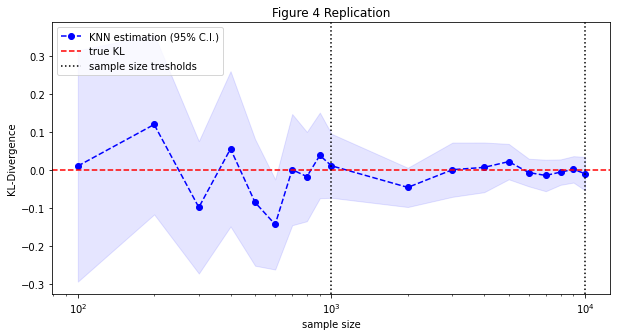

In [ ]:
# Initialize parameters (see pg 246; figure 4)
runs= 25
sampleSizes= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000)))#, np.arange(20000, 110000, 10000)))
mu1= np.zeros(20)
mu2= mu1
cov1= np.ones((20,20))*0.2
np.fill_diagonal(cov1, 1)
cov2= cov1
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachSize in sampleSizes:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, eachSize)
        s2= np.random.multivariate_normal(mu2, cov2, eachSize)
        kl= KLdivergence(s1,s2) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)   
    print("----------------")
    print('sample size finished:', eachSize )

# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(sampleSizes, results, linestyle='--', marker='o', color='b')
plt.fill_between(sampleSizes, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axhline(y= 0, linestyle='--', color='r');
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('sample size')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'true KL', 'sample size tresholds']);
plt.title('Figure 4 Replication'); 

### Two identical multivariate dimensions with increasing dimensionality 

- We observe that the variance of the estimator increases as a function of the dimension size of the distributions.
- We also observe that the variance of the estimator decreases as a function of the sample size. 

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


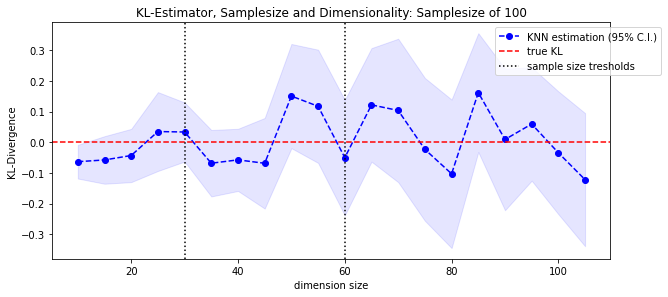

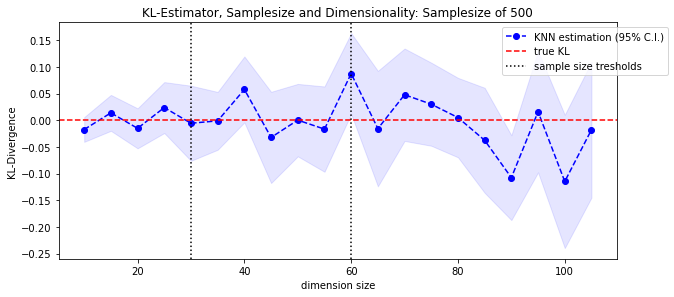

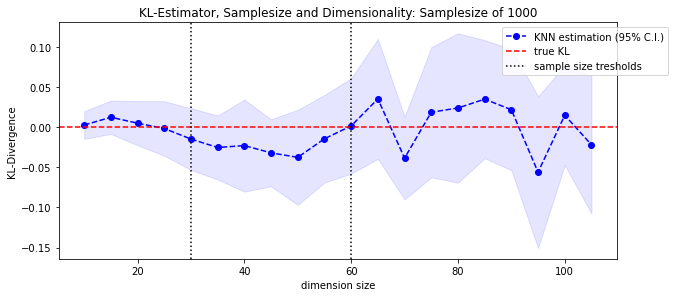

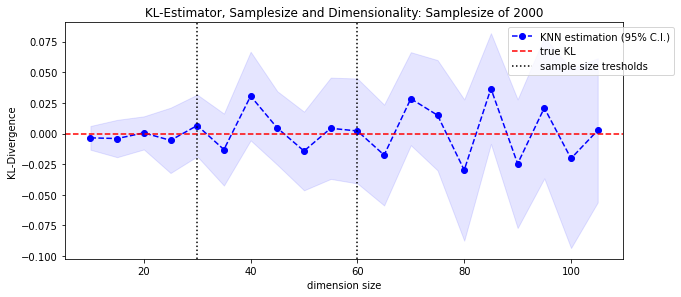

In [4]:
# Initialize parameters (see pg 246; figure 4)
runs= 25
sampleSize= [100, 500, 1000, 2000]
dimensions= np.arange(10, 110, 5)
results= []
lower_ci= []
upper_ci= []
subplot= 1
for eachSize in sampleSize:
  results= []
  lower_ci= []
  upper_ci= []
  # Generate distributions and estimate KL-divergence  
  for eachDim in dimensions:
      kl_tmp= []
      for eachRun in range(runs):
          mu1= np.zeros(eachDim)
          mu2= mu1
          cov1= np.ones((eachDim,eachDim))*0.2
          np.fill_diagonal(cov1, 1)
          cov2= cov1
          s1= np.random.multivariate_normal(mu1, cov1, eachSize)
          s2= np.random.multivariate_normal(mu2, cov2, eachSize)
          kl= KLdivergence(s1,s2, k=10) 
          kl_tmp.append(kl)
          lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
      results.append(np.mean(kl_tmp))
      lower_ci.append(lower_ci_tmp)
      upper_ci.append(upper_ci_tmp)   
      #print("----------------")
      #print('sample size finished:', eachDim )

  # Plot results 
  plt.figure(figsize=[10, 20])

  plt.subplot(len(sampleSize),1,subplot)
  plt.plot(dimensions, results, linestyle='--', marker='o', color='b')
  plt.fill_between(dimensions, lower_ci, upper_ci, color='b', alpha=.1)
  plt.axhline(y= 0, linestyle='--', color='r');
  plt.axvline(x= 30, linestyle=':', color='k')
  plt.axvline(x= 60, linestyle=':', color='k')
  plt.xlabel('dimension size')
  plt.ylabel('KL-Divergence')
  plt.legend(['KNN estimation (95% C.I.)', 'true KL', 'sample size tresholds'], bbox_to_anchor=(1.1, 1));
  plt.title('KL-Estimator, Samplesize and Dimensionality: Samplesize of %i' %eachSize); 
  subplot+= 1

### Two multivariate distributions with increasing mean differences 

- We observe a linear relationship between the KL-divergence and the log difference between the means of two multivariate Gaussian distributions. 

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


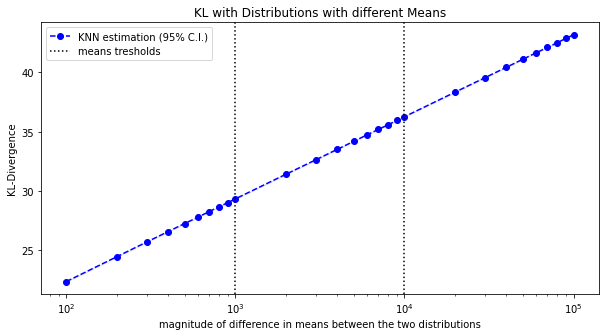

In [ ]:
# Initialize parameters
runs= 25
sampleSize= 10000
mu1= [0,0,0]
means= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))
mu2= np.ones(3)*means[:, None]
cov1= np.zeros((3,3))
np.fill_diagonal(cov1, 1)
cov2= cov1
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachMean in range(len(mu2)):
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, sampleSize)
        s2= np.random.multivariate_normal(mu2[eachMean, :], cov2, sampleSize)
        kl= KLdivergence(s1,s2) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)    

# Plot results 
plt.figure(figsize=[10,5])
plt.plot(means, results, linestyle='--', marker='o', color='b')
plt.fill_between(means, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('magnitude of difference in means between the two distributions')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'means tresholds']);
plt.title('KL with Distributions with different Means'); 
plt.show()

### Two multivariate distributions with increasing variance differences 


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


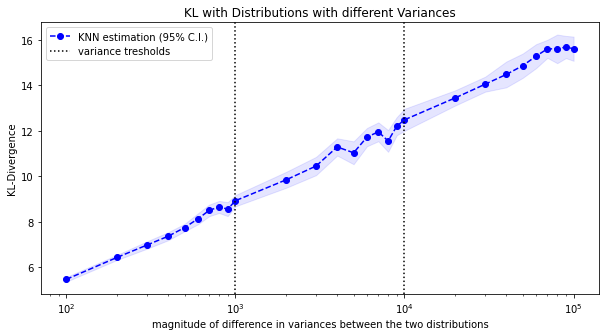

In [ ]:
# Initialize parameters
runs= 25
sampleSize= 10000
mu1= [0,0,0]
mu2= mu1
cov1= np.zeros((3,3))
np.fill_diagonal(cov1, 1)
cov2= np.zeros((3,3))
np.fill_diagonal(cov2, 1)
variances= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachVariance in variances:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, sampleSize)
        np.fill_diagonal(cov2, eachVariance)
        s2= np.random.multivariate_normal(mu2, cov2, sampleSize)
        kl= KLdivergence(s1,s2) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)    

# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(variances, results, linestyle='--', marker='o', color='b')
plt.fill_between(variances, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('magnitude of difference in variances between the two distributions')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'variance tresholds']);
plt.title('KL with Distributions with different Variances'); 

### Two multivariate distributions with increasing covariance differences 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


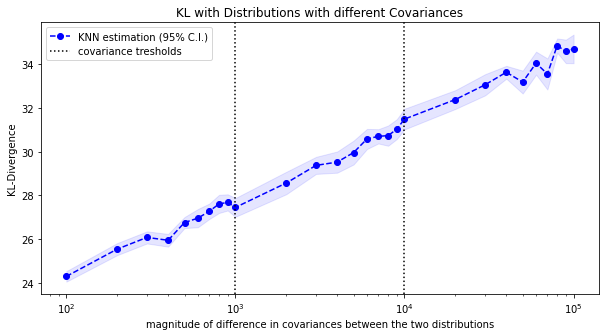

In [ ]:
# Initialize parameters
runs= 25
sampleSize= 10000
mu1= [0,0,0]
mu2= mu1
cov1= np.ones((3,3))
covariances = np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))
results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence  
for eachCovariance in covariances:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, sampleSize)
        cov2= np.ones((3,3))*eachCovariance
        np.fill_diagonal(cov2, 1)
        s2= np.random.multivariate_normal(mu2, cov2, sampleSize)
        kl= KLdivergence(s1,s2) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)

# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(covariances, results, linestyle='--', marker='o', color='b')
plt.fill_between(covariances, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('magnitude of difference in covariances between the two distributions')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'covariance tresholds']);
plt.title('KL with Distributions with different Covariances'); 

### Two multivariate distributions with increasing mean, variance and covariance differences 


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/weightstats.py:225: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


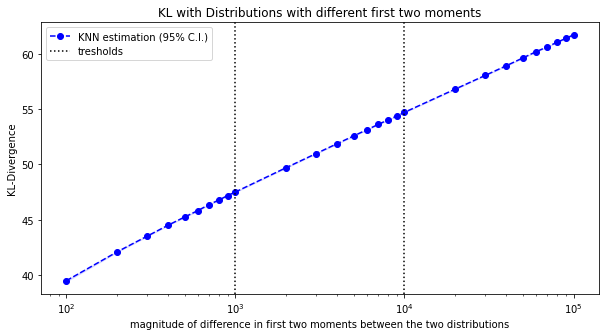

In [ ]:
# Initialize parameters
runs= 25
sampleSize= 10000
mu1= [0,0,0]
cov1= np.ones((3,3))

#set of means 
means= np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))
mu2= np.ones(3)*means[:, None]


#set of covariances 
covariances = np.concatenate((np.arange(100, 1100, 100), np.arange(2000, 11000, 1000), np.arange(20000, 110000, 10000)))

results= []
lower_ci= []
upper_ci= []

# Generate distributions and estimate KL-divergence 
idx= 0
for eachCovariance in covariances:
    kl_tmp= []
    for eachRun in range(runs):
        s1= np.random.multivariate_normal(mu1, cov1, sampleSize)
        cov2= np.ones((3,3))*eachCovariance
        np.fill_diagonal(cov2, eachCovariance)
        s2= np.random.multivariate_normal(mu2[idx,:], cov2, sampleSize)
        kl= KLdivergence(s1,s2) 
        kl_tmp.append(kl)
        lower_ci_tmp, upper_ci_tmp= sms.DescrStatsW(kl_tmp).tconfint_mean()
    results.append(np.mean(kl_tmp))
    lower_ci.append(lower_ci_tmp)
    upper_ci.append(upper_ci_tmp)
    idx+= 1
    
# Plot results 
plt.figure(figsize=[10, 5])
plt.plot(means, results, linestyle='--', marker='o', color='b')
plt.fill_between(means, lower_ci, upper_ci, color='b', alpha=.1)
plt.xscale('log')
plt.axvline(x= 1000, linestyle=':', color='k')
plt.axvline(x= 10000, linestyle=':', color='k')
plt.xlabel('magnitude of difference in first two moments between the two distributions')
plt.ylabel('KL-Divergence')
plt.legend(['KNN estimation (95% C.I.)', 'tresholds']);
plt.title('KL with Distributions with different first two moments'); 

## KL-divergence with mixed multivariate distributions

Financial datasets frequently contain both continuous and discrete variables. Thus, we need to ensure that our KL-divergence estimator is able to handle such mixed multivariate distributions in case we want to apply the estimator to evaluate our synthetic data. 

_Work in progress_

In [ ]:
# import libraries 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



## Distribution A 

# Categorical variable
categories = ['cats', 'dogs', 'pigs']
nominal = np.random.choice(a= categories, size=10000 ,p=[0.5, 0.3, 0.2]  )
datasetNominal= nominal.reshape(-1,1)
# One-Hot Encoding
nameFeatures = ["Animal"]
ohe = OneHotEncoder(sparse= False) #create encoder object 
datasetEncoded = ohe.fit_transform(datasetNominal) #transform nominal data 
datasetEncoded = pd.DataFrame(datasetEncoded) #transform output to df 
datasetEncoded.columns = ohe.get_feature_names(nameFeatures) #name columns appropriately 
# Create noise 
noise = np.random.uniform(0, 0.2, datasetEncoded.shape) #noise level of 0.2 is the standard 
# Add noise to dataset 
dataset_with_noise = datasetEncoded.values + noise 
# Normalize noise input 
datasetNominalNormalized = dataset_with_noise / np.sum(dataset_with_noise, axis= 1)[:, None]

# Continuous variable 
mu= 10
std= 2
n_samples= 10000
# Generate dataset  
univariate= np.random.normal(loc= mu, scale= std, size= n_samples).reshape(-1,1)
maximum= univariate.max()
minimum= univariate.min()
# Normalize for tanh
datasetUnivariateNormalized= 2 * (univariate - np.min(univariate)) / (np.max(univariate) - np.min(univariate)) - 1

# Full dataset
datasetA= np.concatenate((datasetUnivariateNormalized, datasetNominalNormalized), axis=1) 


## Distribution B (changes to categorical propertions)

# Categorical variable
categories = ['cats', 'dogs', 'pigs']
nominal = np.random.choice(a= categories, size=10000 ,p=[0.2, 0.1, 0.7]  )
datasetNominal= nominal.reshape(-1,1)
# One-Hot Encoding
nameFeatures = ["Animal"]
ohe = OneHotEncoder(sparse= False) #create encoder object 
datasetEncoded = ohe.fit_transform(datasetNominal) #transform nominal data 
datasetEncoded = pd.DataFrame(datasetEncoded) #transform output to df 
datasetEncoded.columns = ohe.get_feature_names(nameFeatures) #name columns appropriately 
# Create noise 
noise = np.random.uniform(0, 0.2, datasetEncoded.shape) #noise level of 0.2 is the standard 
# Add noise to dataset 
dataset_with_noise = datasetEncoded.values + noise 
# Normalize noise input 
datasetNominalNormalized = dataset_with_noise / np.sum(dataset_with_noise, axis= 1)[:, None]

# Continuous variable 
mu= 10
std= 2
n_samples= 10000
# Generate dataset  
univariate= np.random.normal(loc= mu, scale= std, size= n_samples).reshape(-1,1)
maximum= univariate.max()
minimum= univariate.min()
# Normalize for tanh
datasetUnivariateNormalized= 2 * (univariate - np.min(univariate)) / (np.max(univariate) - np.min(univariate)) - 1

# Full dataset
datasetB= np.concatenate((datasetUnivariateNormalized, datasetNominalNormalized), axis=1) 

In [ ]:
KLdivergence(datasetA,datasetB)

0.7321041845994395